In [1]:
import os
import json
import torch
import textwrap
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from datetime import datetime
from datasets import load_dataset  # Hugging Face Datasets
from transformers import AlbertTokenizer, AlbertModel, AlbertConfig

### Dataload & Params

In [2]:
# PARAMS
min_words = 300
max_words = 500
drop_diagonal = False
n_hidden_layers = 24
n_attention_heads = 1

# Create a directory to save the plots
date_time = datetime.now().strftime("%Y%m%d_%H%M%S")
folder_name = f"{date_time}_hl={n_hidden_layers}"
output_path = f"../plots/{folder_name}"
os.makedirs(output_path, exist_ok=True)

params = {
    "min_words": min_words,
    "max_words": max_words,
    "drop_diagonal": drop_diagonal,
    "n_hidden_layers": n_hidden_layers,
    "n_attention_heads": n_attention_heads,
}
with open(os.path.join(output_path, "params.json"), "w") as f:
    json.dump(params, f, indent=4)

In [3]:
# Load the WikiText-103 dataset (version 1)
wikitext = load_dataset("wikitext", "wikitext-103-v1")

# The WikiText language modeling dataset is a collection of over 100 million tokens
# extracted from the set of verified Good and Featured articles on Wikipedia

# Each example in the dataset is a complete Wikipedia article
# The articles are preprocessed and split into sections

### Define Model

In [4]:
al_tkz = AlbertTokenizer.from_pretrained("albert-xlarge-v2")
# al_model = AlbertModel.from_pretrained("albert-xlarge-v2")

alm2_config = AlbertConfig.from_pretrained(
    "albert-xlarge-v2",
    num_hidden_layers=n_hidden_layers,
    num_attention_heads=n_attention_heads,
)
al_model = AlbertModel.from_pretrained("albert-xlarge-v2", config=alm2_config)

print("hidden layers: ", al_model.config.num_hidden_layers)
print("attention heads: ", al_model.config.num_attention_heads)

hidden layers:  24
attention heads:  1


In [5]:
# Print model architecture and params
print(al_model)
print(al_model.config.to_json_string())

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(30000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=2048, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((2048,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertSdpaAttention(
              (query): Linear(in_features=2048, out_features=2048, bias=True)
              (key): Linear(in_features=2048, out_features=2048, bias=True)
              (value): Linear(in_features=2048, out_features=2048, bias=True)
              (attention_dropout): Dropout(p=0, inplace=F

### Random Input

In [6]:
def get_random_input(dataset, tokenizer, min_words=300, max_words=500):
    """
    Get a random input sequence from the dataset that meets minimum length requirements.

    dataset: HuggingFace dataset containing text data
    tokenizer: Tokenizer to convert text to model input format

    Q = why only use sequences longer than 300 tokens?
    A = because the model is large and the input sequence needs to be long enough to activate all the parameters

    Returns dictionary containing tokenized input with keys:
    - input_ids: Tensor of token IDs
    - token_type_ids: ???
    - attention_mask: Tensor of attention masks ( Q = why is this needed? )
    """
    n_train = len(dataset["train"])

    # # keep trying until we find a sequence longer than 300 tokens
    # while True:
    #     # random index in training data
    #     it = np.random.randint(n_train)
    #     print(f"trying {it}")
    #     text = dataset["train"][it]["text"]
    #     # tokenize with padding and truncation
    #     ei = tokenizer(text, return_tensors="pt", truncation=True)
    #     # termination condition
    #     if ei["input_ids"].shape[1] > 300:
    #         break

    start_idx = np.random.randint(n_train)
    collected_words = []
    word_count = 0

    for i in range(start_idx, n_train):
        new_words = dataset["train"][i]["text"].split()
        word_count += len(new_words)
        collected_words.extend(new_words)

        if word_count > max_words:
            # Drop the last chunk to stay within the limit
            collected_words = collected_words[: -len(new_words)]
            last_idx = i - 1
            break
        elif word_count > min_words:
            last_idx = i
            break

    text = " ".join(collected_words)
    ei = tokenizer(text, return_tensors="pt", truncation=True)
    return ei, start_idx, last_idx

In [7]:
ei, start_idx, last_idx = get_random_input(wikitext, al_tkz, min_words, max_words)

print("- " * 20)
print("Random Input:")
decoded_text = al_tkz.batch_decode(
    ei["input_ids"],
    # skip_special_tokens=True
)
wrapped_text = [textwrap.fill(t, width=100) for t in decoded_text]
print("\n\n".join(wrapped_text))
print("- " * 20)

- - - - - - - - - - - - - - - - - - - - 
Random Input:
[CLS] this is a table of the storms in 1973 and their landfall ( s ) , if any . deaths in
parentheses are additional and indirect ( an example of an indirect death would be a traffic
accident ) , but are still storm <unk> -<unk> related . damage and deaths include totals while the
storm was extratropical or a wave or low . = 2 / 4th machine gun battalion ( australia ) = the 2 /
4th machine gun battalion was an australian army unit raised for service with the all volunteer
second australian imperial force ( 2nd aif ) during the second world war . formed in late 1940 as
part of the 8th division , the battalion was established to provide direct fire support to the
division <unk> s infantry brigades . it was the fourth , and last , such unit raised within the 2nd
aif . the unit 's personnel were largely drawn from the state of western australia and after
formation , the battalion concentrated near perth for basic individual training be

### Calc Corr

In [8]:
def compute_correlations(hidden_states, drop_diagonal=True):
    """
    Compute pairwise correlations between token representations for each layer's hidden states.

    hidden_states (list):
        List of tensors containing hidden states from each layer of the model.
        Each tensor has shape (batch_size=1, sequence_length, hidden_dim)

    Returns list of tensors containing flattened correlation matrices for each layer.
    Each tensor contains the pairwise correlations between all tokens in that layer.
    The correlations are computed as cosine similarities between normalized token representations.
    """
    corrs = []
    for hs in hidden_states:
        # Remove batch dimension and create a copy without gradient tracking
        T = hs.squeeze(0).clone().detach().requires_grad_(False)
        # Normalize each token's representation to unit length for cosine similarity
        T = torch.nn.functional.normalize(T, dim=1)
        # Compute pairwise cosine similarities between all tokens
        T2 = torch.matmul(T, T.transpose(0, 1))

        if drop_diagonal:
            mask = ~torch.eye(T2.size(0), dtype=bool, device=T2.device)
            sim_values = T2[mask].cpu().numpy()
        else:
            sim_values = T2.flatten().cpu().numpy()

        corrs.append(sim_values)
    return corrs

In [9]:
# get output features ... which contains last_hidden_state, pooler_output, hidden_states
# hidden_states is a list of tensors, each tensor has shape (batch_size=1, sequence_length, hidden_dim)
# last_hidden_state has shape (batch_size=1, sequence_length, hidden_dim)
# pooler_output has shape (batch_size=1, hidden_dim)

of = al_model(**ei, output_hidden_states=True)
correls = compute_correlations(of["hidden_states"], drop_diagonal=drop_diagonal)

### Plot KDE

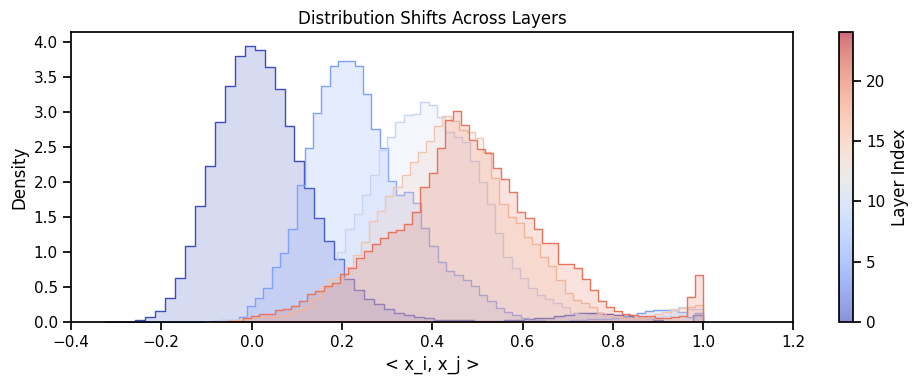

In [10]:
# Create figure and axis
sns.set_context("notebook") # paper, notebook, talk, poster
fig, ax = plt.subplots(figsize=(10, 4))
plt_hist = True

# Create a colormap that transitions from blue to red
cmap = plt.cm.coolwarm
norm = mcolors.Normalize(vmin=0, vmax=len(correls) - 1)

# Plot each histogram with a color based on its layer index
for i, hist in enumerate(correls):
    if i % 5 != 0:
        continue
    color = cmap(norm(i))
    if plt_hist:
        sns.histplot(
            hist,
            bins=60,
            alpha=0.2,
            color=color,
            label=f"Layer {i}",
            stat="density",
            element="step",
        )
    else :
        sns.kdeplot(
            hist,
            fill=True,
            alpha=0.2,
            color=color,
            label=f"Layer {i}",
            ax=ax,
            # bw_adjust=0.6,
        )

# Add legend
# plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), title="Layer Index")

# Add color bar to show layer progression
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Layer Index')

# Make the colorbar content partially transparent
for collection in cbar.ax.collections:
    collection.set_alpha(0.6)

plt.title("Distribution Shifts Across Layers")
plt.xlim(-0.4, 1.2)
plt.xlabel("< x_i, x_j >")
plt.ylabel("Density")
plt.tight_layout()

# Save figure
plt_path = os.path.join(output_path, f"albert_fig1_{n_hidden_layers}_{"hist" if plt_hist else "kde"}.pdf")
plt.savefig(plt_path, dpi=300, bbox_inches="tight")

plt.show()

### Plot Corr

In [11]:
# Save the input text as txt file in the folder
txt_fname = f"input_text_{start_idx}_{last_idx}"
with open(f"{output_path}/{txt_fname}.txt", "w") as f:
    f.write(decoded_text[0])

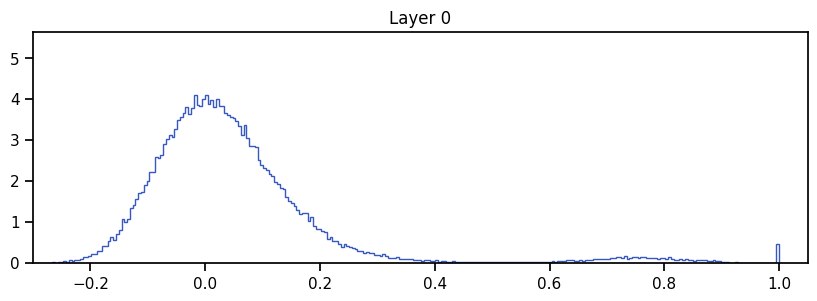

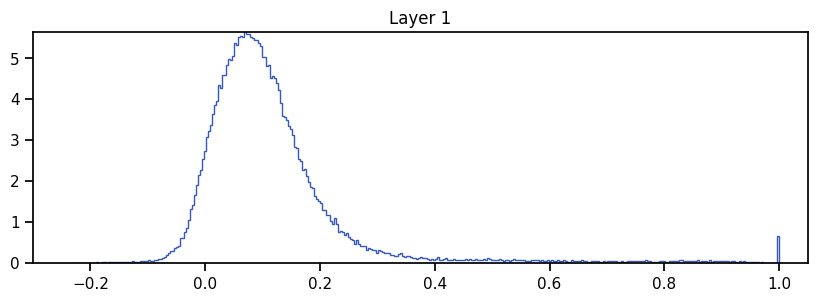

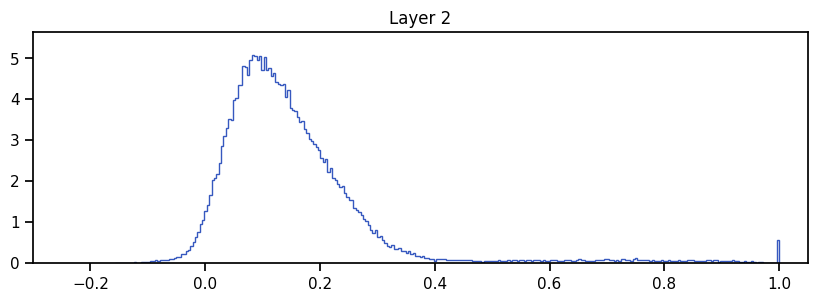

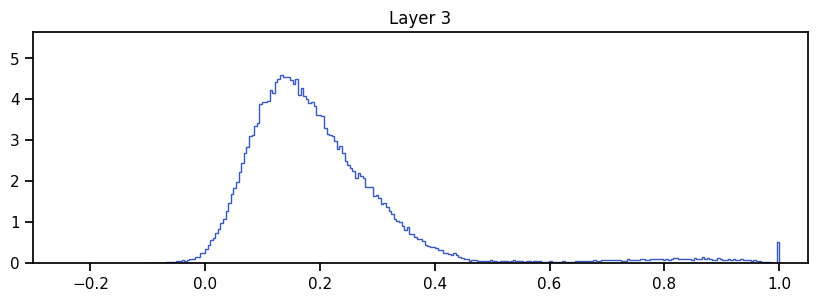

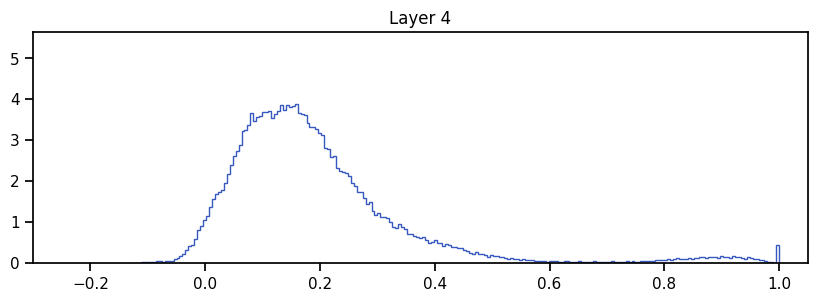

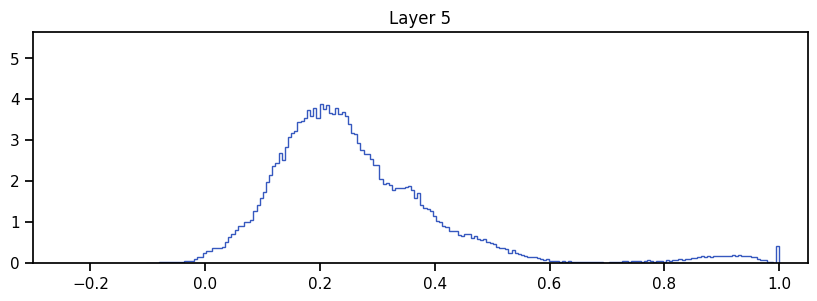

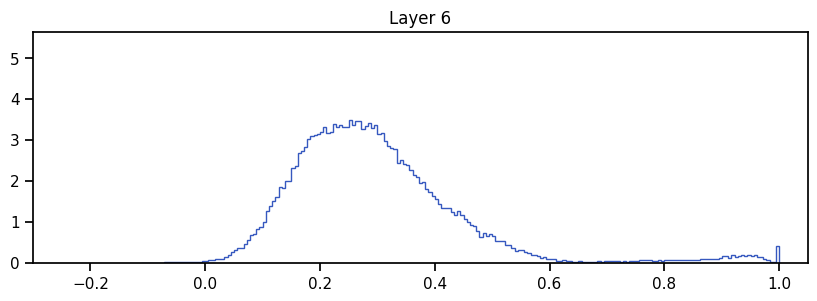

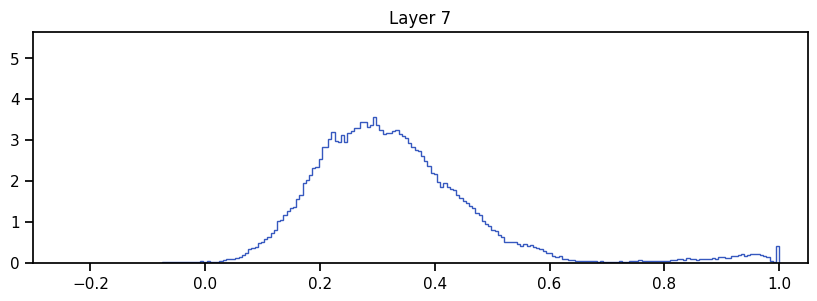

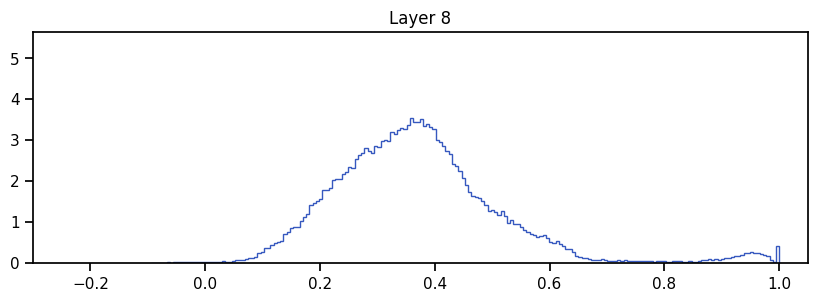

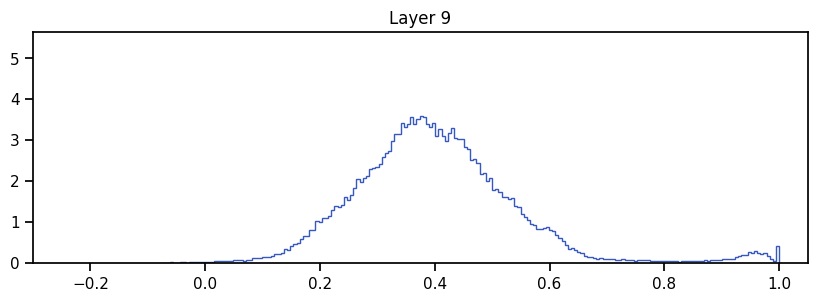

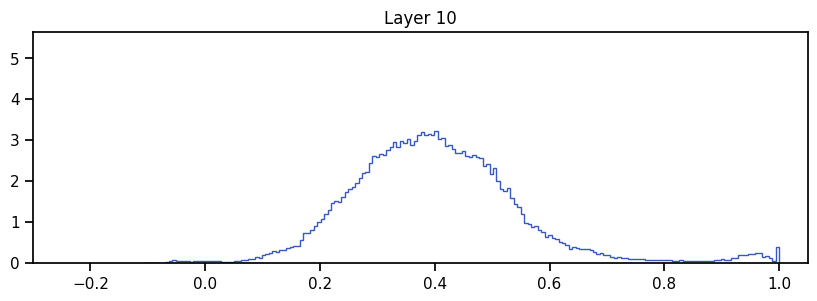

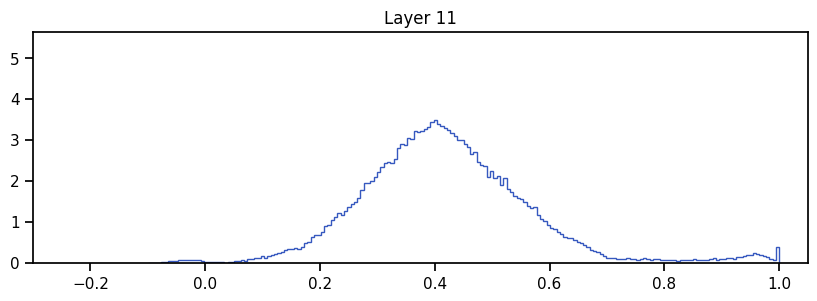

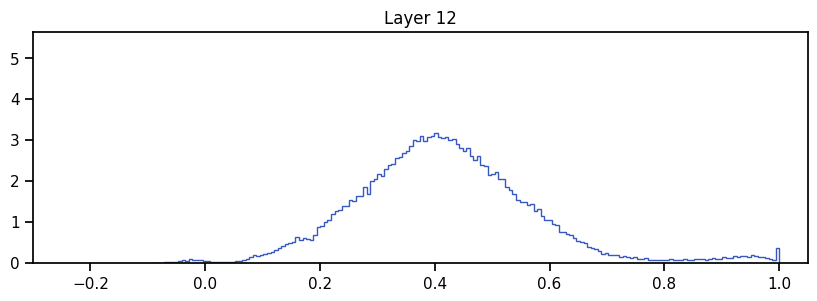

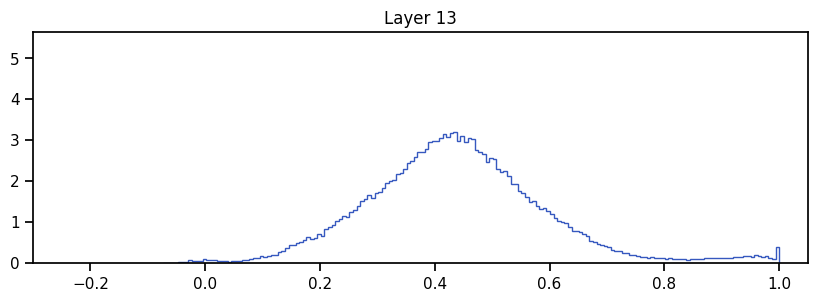

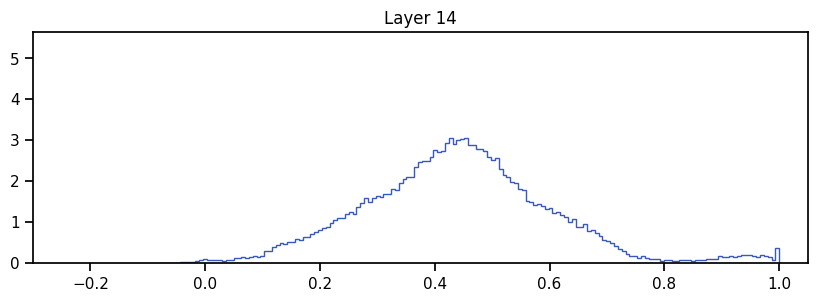

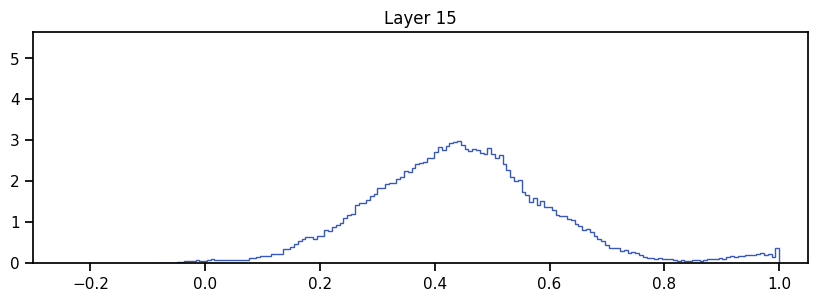

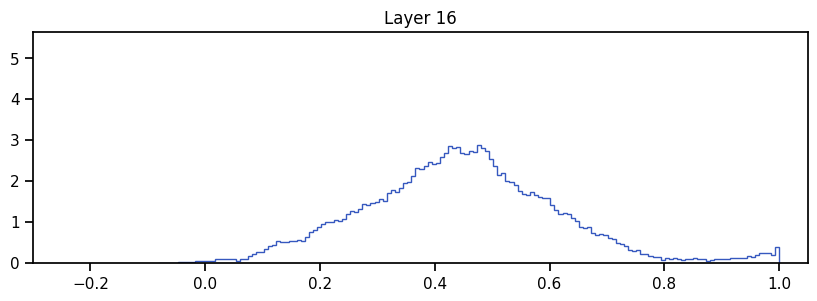

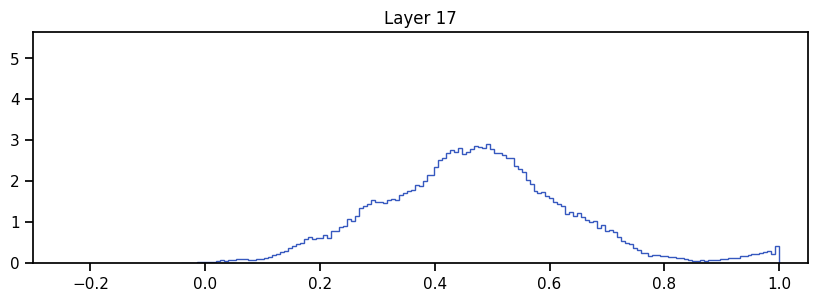

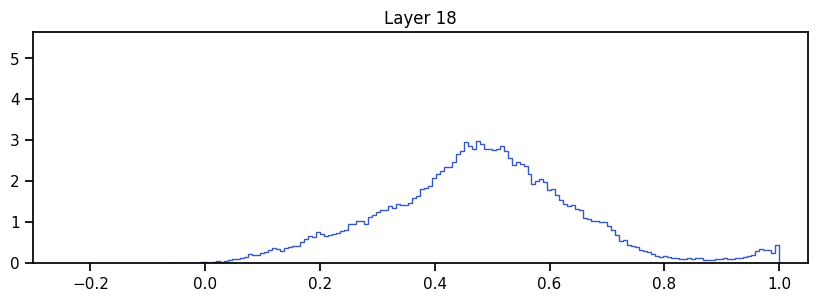

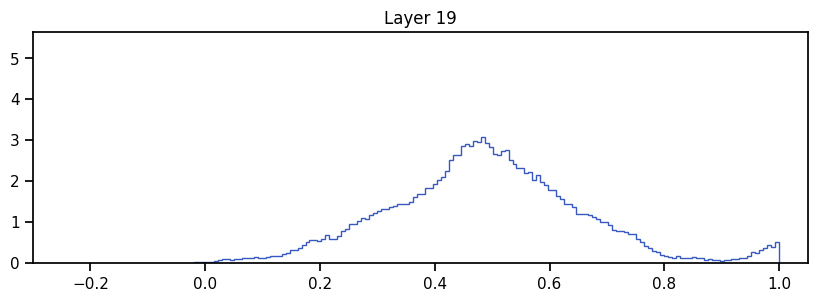

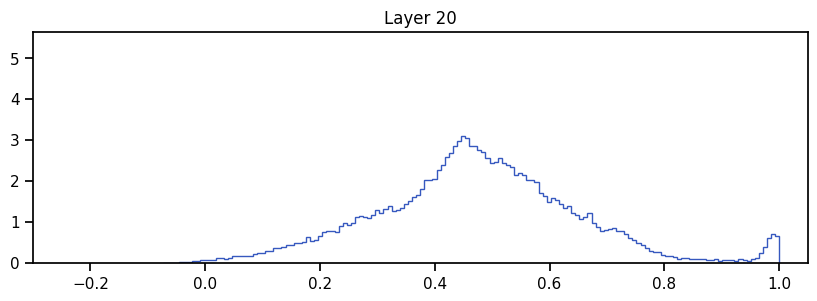

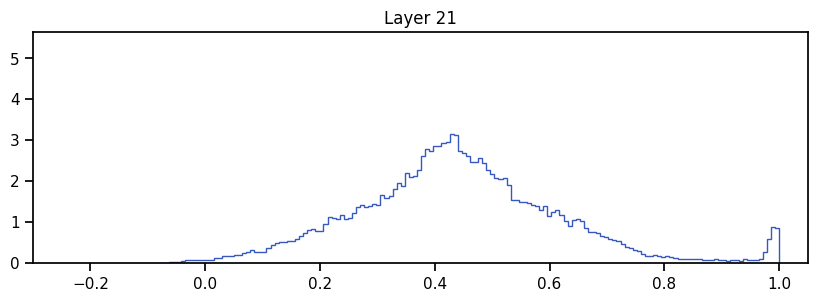

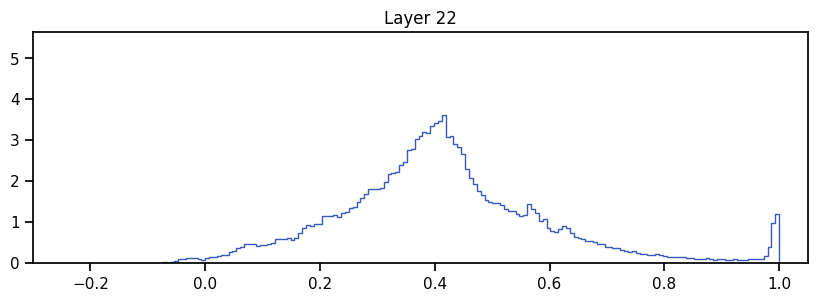

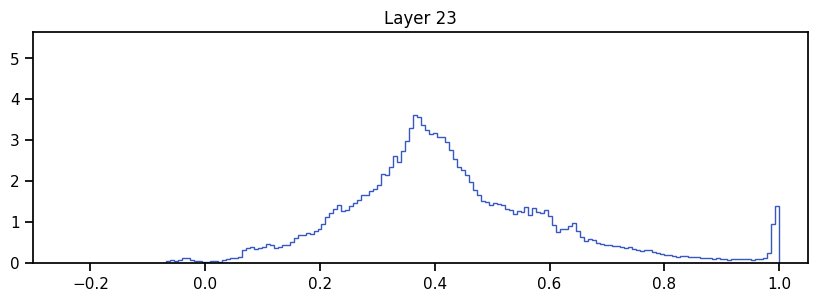

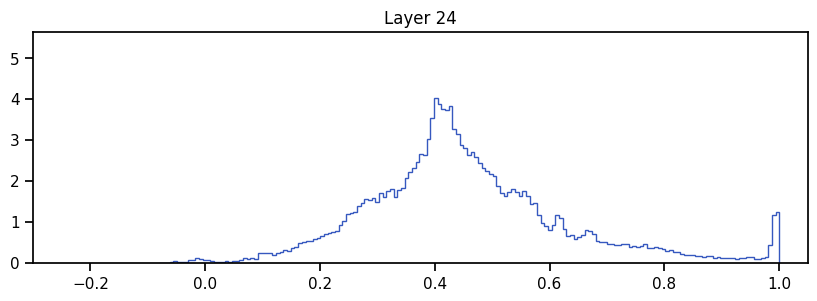

In [12]:
# Create and save individual histogram plots for each layer's token correlations.
# Use adaptive binning based on data distribution and consistent x,y-axis scaling across all plots.

# determine global max density (y) value
max_density = 0
for data in correls:
    counts, bin_edges = np.histogram(data, bins=100, density=True)
    max_density = max(max_density, max(counts))

for i, data in enumerate(correls):
    IQR = np.percentile(data, 75) - np.percentile(data, 25)
    n = len(data)
    bin_width = 2 * IQR / n ** (1 / 3)
    bins = int((max(data) - min(data)) / bin_width)

    plt.figure(figsize=(10, 3))
    plt.hist(
        data,
        bins=bins,
        density=True,
        histtype="step",
        color="#3658bf",
        linewidth=1,
    )
    plt.title(f"Layer {i}", fontsize=12)
    plt.xlim(-0.3, 1.05)
    plt.ylim(0, max_density)
    plt.savefig(f"{output_path}/histogram_layer_{i}.pdf")
    plt.show()
    plt.close()